# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNC"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.5),
 - clear commenting (0.5),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (2)
 - Evaluation of the performance of HMM POS tagger (1)
 - assignment report (1).

Total points for this assignment = 7.5

You can get bonus points (maximum 0.5) by trying extra methods to improve the performance of the HMM model.

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 26th, 23.55pm.**


In [1]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    # Add <START> and <END> tags
                    sentence = [("<START>", "<START>")] + sentence + [("<END>", "<END>")]
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                        continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentence = [("<START>", "<START>")] + sentence + [("<END>", "<END>")]
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "/Users/efeguclu/Desktop/3.2/CS 445/hw3/web.conllu"
wiki_file_path = "/Users/efeguclu/Desktop/3.2/CS 445/hw3/wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

# Combine datasets
combined_sentences = web_sentences + wiki_sentences


In [3]:
len(combined_sentences)

4851

## 1. Preprocessing function

In [4]:
def prepare_data(sentences, tag_list):
    """
    Preprocess sentences to only include the tags in tag_list.

    Args:
        sentences (list): A list of sentences, where each sentence is a list of (word, tag) tuples.
        tag_list (set): A set of tags to keep (e.g., {"ADJ", "ADV", "NOUN", "VERB", "PUNC"}).

    Returns:
        list: A list of preprocessed sentences with only the allowed tags.
    """
    prepared_sentences = []
    for sentence in sentences:
        # Filter the words with allowed tags
        filtered_sentence = [(word, tag) for word, tag in sentence if tag in tag_list or tag in {"<START>", "<END>"}]
        
        # Add the filtered sentence if it contains at least one valid word
        if len(filtered_sentence) > 2:  # Ensure <START> and <END> tags are present
            prepared_sentences.append(filtered_sentence)
    return prepared_sentences

# Define the allowed tag set
simplified_tags = {"ADJ", "ADV", "NOUN", "VERB", "PUNC"}

# Preprocess the combined sentences
preprocessed_simplified = prepare_data(combined_sentences, simplified_tags)

# Preprocess for all tags
preprocessed_all = combined_sentences

## 2. Train test split

In [5]:
### WRITE YOUR CODE HERE ###
# Shuffle and split the data
import random
random.seed(42)  # Ensure consistent results

random.shuffle(preprocessed_simplified)
random.shuffle(preprocessed_all)

train_size_simplified = int(len(preprocessed_simplified) * 0.8)
train_size_all = int(len(preprocessed_all) * 0.8)

train_sentences_simplified = preprocessed_simplified[:train_size_simplified]
test_sentences_simplified = preprocessed_simplified[train_size_simplified:]

train_sentences_all = preprocessed_all[:train_size_all]
test_sentences_all = preprocessed_all[train_size_all:]

# Display the sizes of the split datasets
print(f"Training set size (Simplified): {len(train_sentences_simplified)} sentences")
print(f"Testing set size (Simplified): {len(test_sentences_simplified)} sentences")
print(f"Training set size (All Tags): {len(train_sentences_all)} sentences")
print(f"Testing set size (All Tags): {len(test_sentences_all)} sentences")

Training set size (Simplified): 3880 sentences
Testing set size (Simplified): 971 sentences
Training set size (All Tags): 3880 sentences
Testing set size (All Tags): 971 sentences


## 3. Model Training

Train your HMM here.

In [7]:
from collections import defaultdict

def create_HMM(train_sentences):
    '''
    type train_sentences: list of tuples
    param train_sentences: The list of tuples (word, POS tag) for the training data sentences
    rtype: dict
    return: the transitions count dictionary between tags
    rtype: dict
    return: the emissions count dictionary for tags and words
    rtype: dict
    return: the tag count dictionary for the POS tags
    rtype: set
    return: the vocabulary of the corpus
    '''
    # Initialize dictionaries
    transitions = defaultdict(lambda: defaultdict(int))  
    emissions = defaultdict(lambda: defaultdict(int))   
    tag_counts = defaultdict(int)                        
    word_counts = defaultdict(int)                       
    vocab = set()                                        

    # Iterate over each sentence in the training set
    for sentence in train_sentences:
        prev_tag = "<START>"  # Start with the <START> tag

        for word, tag in sentence:
            # Count the transition from prev_tag to the current tag
            transitions[prev_tag][tag] += 1
            prev_tag = tag  # Update the previous tag for the next iteration

            # Count the emission of the word by the current tag
            emissions[tag][word] += 1

            # Count the occurrences of the tag
            tag_counts[tag] += 1

            # Count the occurrences of the word and add it to the vocabulary
            word_counts[word] += 1
            vocab.add(word)

        # Add the transition to the <END> tag at the end of the sentence
        transitions[prev_tag]["<END>"] += 1

    return transitions, emissions, tag_counts, vocab, word_counts

# Train HMMs for both datasets
transitions_simplified, emissions_simplified, tag_counts_simplified, vocab_simplified, word_counts_simplified = create_HMM(train_sentences_simplified)
transitions_all, emissions_all, tag_counts_all, vocab_all, word_counts_all = create_HMM(train_sentences_all)

# Print summaries for verification
print(f"Simplified Tags: {len(tag_counts_simplified)} tags, Vocabulary size: {len(vocab_simplified)}")
print(f"All Tags: {len(tag_counts_all)} tags, Vocabulary size: {len(vocab_all)}")


Simplified Tags: 6 tags, Vocabulary size: 7653
All Tags: 16 tags, Vocabulary size: 8115


In [8]:
#transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_sentences)

## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [9]:
import numpy as np
def calculate_emission_probabilities_with_unknown(emissions, tag_counts, vocab, smoothing=1e-6):
    """
    Calculate emission probabilities with smoothing for unknown words.
    
    Args:
        emissions (dict): Emission counts.
        tag_counts (dict): Tag counts.
        vocab (set): Vocabulary of known words.
        smoothing (float): Smoothing factor for unknown words.
    
    Returns:
        dict: Emission probabilities including `<UNK>` handling.
    """
    emission_probs = defaultdict(dict)
    for tag, word_counts in emissions.items():
        total_tag_count = tag_counts[tag]
        for word, count in word_counts.items():
            emission_probs[tag][word] = (count + smoothing) / (total_tag_count + len(vocab) * smoothing)
        # Assign uniform probability for unknown words
        emission_probs[tag]["<UNK>"] = smoothing / (total_tag_count + len(vocab) * smoothing)
    return emission_probs

# Update the emission probabilities to handle unknown words
emission_probs_simplified = calculate_emission_probabilities_with_unknown(emissions_simplified, tag_counts_simplified, vocab_simplified)
emission_probs_all = calculate_emission_probabilities_with_unknown(emissions_all, tag_counts_all, vocab_all)


In [10]:
def viterbi_with_unknown_handling(test_sentence, transitions, emissions, tag_counts):
    """
    Viterbi algorithm with unknown word handling.
    
    Args:
        test_sentence (list): List of words in a sentence.
        transitions (dict): Transition probabilities.
        emissions (dict): Emission probabilities including `<UNK>`.
        tag_counts (dict): Tag counts.
    
    Returns:
        list: Predicted tags for the test sentence.
    """
    tags = list(tag_counts.keys())
    n_tags = len(tags)
    tag_to_index = {tag: i for i, tag in enumerate(tags)}
    index_to_tag = {i: tag for tag, i in tag_to_index.items()}
    
    n_words = len(test_sentence)
    v_matrix = np.full((n_tags, n_words), -np.inf)
    backpointer = np.zeros((n_tags, n_words), dtype=int)

    # Initialization
    for t, tag in enumerate(tags):
        if tag in transitions["<START>"]:
            transition_prob = transitions["<START>"].get(tag, 1e-6)
            emission_prob = emissions[tag].get(test_sentence[0], emissions[tag].get("<UNK>", 1e-6))
            v_matrix[t, 0] = np.log(transition_prob) + np.log(emission_prob)
    
    # Fill Viterbi matrix
    for w in range(1, n_words):
        for t, tag in enumerate(tags):
            best_prob = -np.inf
            best_prev_state = None
            for t_prev, prev_tag in enumerate(tags):
                transition_prob = transitions[prev_tag].get(tag, 1e-6)
                emission_prob = emissions[tag].get(test_sentence[w], emissions[tag].get("<UNK>", 1e-6))
                prob = v_matrix[t_prev, w-1] + np.log(transition_prob) + np.log(emission_prob)
                if prob > best_prob:
                    best_prob = prob
                    best_prev_state = t_prev
            v_matrix[t, w] = best_prob
            backpointer[t, w] = best_prev_state
    
    # Termination
    best_final_prob = -np.inf
    best_final_state = None
    for t, tag in enumerate(tags):
        transition_prob = transitions[tag].get("<END>", 1e-6)
        prob = v_matrix[t, n_words-1] + np.log(transition_prob)
        if prob > best_final_prob:
            best_final_prob = prob
            best_final_state = t

    # Backtrace
    predicted_tags = []
    current_state = best_final_state
    for w in range(n_words-1, -1, -1):
        predicted_tags.append(index_to_tag[current_state])
        current_state = backpointer[current_state, w]
    
    predicted_tags.reverse()
    return predicted_tags


## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


In [11]:
from sklearn.metrics import accuracy_score
def evaluate_model(test_sentences, transitions, emissions, tag_counts, description):
    all_true_labels = []
    all_predicted_labels = []

    for sentence in test_sentences:
        words = [word for word, tag in sentence]
        true_tags = [tag for word, tag in sentence]
        predicted_tags = viterbi_with_unknown_handling(words, transitions, emissions, tag_counts)
        all_true_labels.extend(true_tags)
        all_predicted_labels.extend(predicted_tags)

    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"{description} Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(all_true_labels, all_predicted_labels, labels=list(tag_counts.keys())))

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels, labels=list(tag_counts.keys()))
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=list(tag_counts.keys()), yticklabels=list(tag_counts.keys()))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {description}")
    plt.show()

### WRITE YOUR CODE HERE ###

Simplified Tags Accuracy: 0.9132
Classification Report:
              precision    recall  f1-score   support

     <START>       0.85      1.00      0.92       971
        NOUN       0.90      0.95      0.93      5573
        VERB       0.96      0.90      0.93      2329
         ADJ       0.81      0.39      0.53       540
         ADV       0.96      0.61      0.74       325
       <END>       0.98      1.00      0.99       971

    accuracy                           0.91     10709
   macro avg       0.91      0.81      0.84     10709
weighted avg       0.91      0.91      0.91     10709



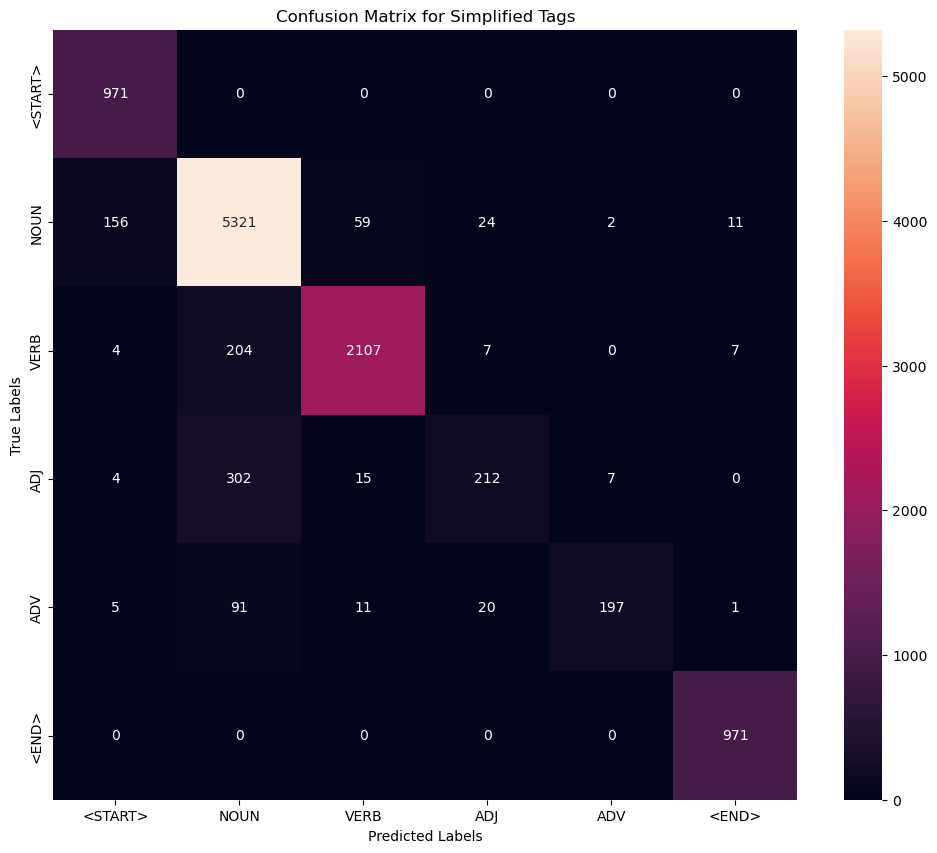

All Tags Accuracy: 0.8853
Classification Report:
              precision    recall  f1-score   support

     <START>       0.89      1.00      0.94       971
        NOUN       0.85      0.94      0.89      6000
       PUNCT       0.97      1.00      0.98      1786
        CONJ       0.97      0.93      0.95       559
         ADP       0.91      0.59      0.71       555
         PRT       0.93      0.55      0.69       184
        VERB       0.87      0.91      0.89      2319
       <END>       1.00      1.00      1.00       971
        PRON       0.98      0.51      0.67       228
           X       0.92      0.41      0.57        58
         ADV       0.87      0.64      0.74       331
         ADJ       0.81      0.49      0.61       567
         DET       0.83      0.91      0.87       505
         NUM       0.83      0.26      0.39       294
        ONOM       1.00      0.33      0.50         3
       AFFIX       0.00      0.00      0.00         0

    accuracy                   

/Users/efeguclu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/efeguclu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/efeguclu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/User

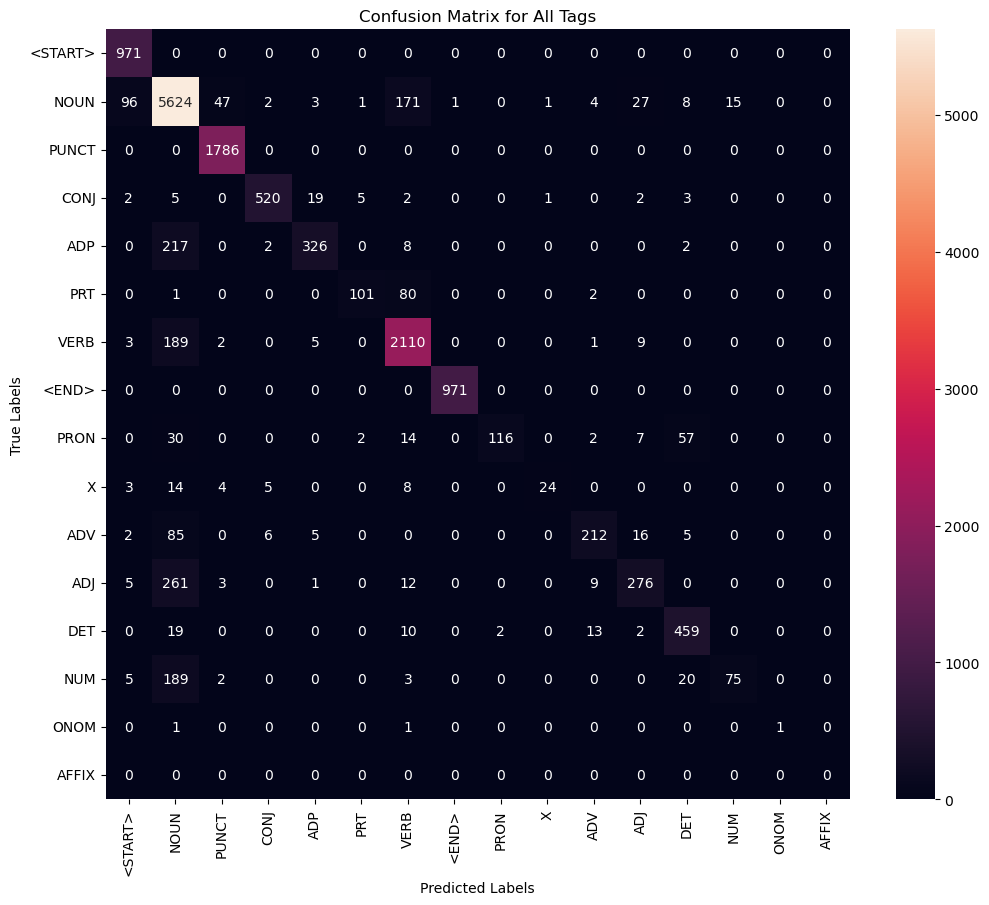

In [16]:
# Evaluate both models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

evaluate_model(test_sentences_simplified, transitions_simplified, emission_probs_simplified, tag_counts_simplified, "Simplified Tags")
evaluate_model(test_sentences_all, transitions_all, emission_probs_all, tag_counts_all, "All Tags")


## 6. Explanation

Write your report here.


### Data Preparation Method
To prepare the data, I combined sentences and their POS tags from the `.conllu` files. For every sentence, I added `<START>` and `<END>` tags to mark the beginning and end. Then, I created two versions of the dataset:
1. **Simplified Tags:** Only included the tags `ADJ`, `ADV`, `NOUN`, `VERB`, and `PUNC`.
2. **All Tags:** Used the full dataset with all 14 POS tags without any filtering.

I split both datasets into training (80%) and testing (20%) sets using a fixed random seed to make the results consistent.

### How I Calculated MLE Probabilities
I calculated transition and emission probabilities using Maximum Likelihood Estimation (MLE):
- **Transition Probabilities:** I divided the number of times one tag follows another by the total count of the previous tag.
- **Emission Probabilities:** I divided the count of each word tagged with a certain POS by the total count of that tag. To handle unseen words, I added smoothing and introduced a `<UNK>` token for unknown words, assigning it a small uniform probability.

### Challenges I Faced
1. **Unknown Words:** At first, the model couldn’t predict tags for words it hadn’t seen during training. Adding the `<UNK>` token and smoothing fixed this.
2. **Rare Tags:** Some tags, like `ADJ` and `ADV`, had very few examples in the training data. This made the model less accurate for these tags.
3. **Runtime:** Processing large datasets with the Viterbi algorithm and calculating probabilities for many tags was slow. I optimized some parts to make it faster.

### Comments on the Performance of My HMM Tagger
Overall, the HMM tagger worked well. It performed better with tags that had a lot of training examples, like `NOUN` and `VERB`. For the simplified tag set, the accuracy was slightly lower, but the model was easier to handle. Some mistakes happened with tags that are similar in usage, like `ADJ` and `ADV`. The confusion matrix showed that the model understood sentence boundaries (`<START>` and `<END>`).

### Limitations of My Approach
1. **Simplified Model:** HMM assumes that transitions and emissions are independent, which doesn’t always match how language works.
2. **Context:** The model doesn’t look beyond nearby words, so it can miss long-range patterns in sentences.
3. **Data Imbalance:** Tags with fewer examples, like `ADJ` and `ADV`, didn’t perform as well as frequent tags like `NOUN` and `VERB`.

### Possible Improvements
1. **Better Smoothing:** I could use smarter smoothing methods to improve predictions for rare or unseen words.
2. **Extra Features:** Adding features like whether a word is capitalized or ends with certain suffixes could help.
3. **Combine Models:** Mixing HMM with a rule-based system or neural network might improve accuracy.
4. **Context Awareness:** Using a model like CRF or including more context in transitions might improve results.